In [12]:
# imports
import os
import json
import pandas as pd
%pip install SoccerNet
from SoccerNet.Downloader import SoccerNetDownloader
%pip install datasets
from datasets import load_dataset
from tqdm import tqdm
from collections import Counter
import re
import string
%pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
%pip install -U transformers
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset
%pip install -U accelerate
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# soccernet downloads

mySoccerNetDownloader = SoccerNetDownloader(LocalDirectory="./soccernet")

mySoccerNetDownloader.downloadGames(files=["Labels-v2.json"], split=["train", "valid", "test"]) # labels
# mySoccerNetDownloader.downloadDataTask(task="spotting-2023", split=["train", "valid", "test", "challenge"]) # highlight labels for 2023 challenge task
# mySoccerNetDownloader.downloadGames(files=["1_ResNET_TF2.npy", "2_ResNET_TF2.npy"], split=["train", "valid", "test"]) # visual features (not needed)

# mySoccerNetDownloader.password = "Password from NDA" # TODO: we need access
# videos:
# mySoccerNetDownloader.downloadGames(files=["1_224p.mkv", "2_224p.mkv"], split=["train", "valid", "test"]) # 224p resolution
# mySoccerNetDownloader.downloadGames(files=["1_720p.mkv", "2_720p.mkv"], split=["train", "valid", "test"]) # 720p resolution

In [ ]:
"""
    helper function to convert position (milliseconds) to seconds and extract the half from gameTime

    args:
        position (str): the position in milliseconds as a string
        game_time (str): the gameTime string in the format "1 - mm:ss" or "2 - mm:ss"

    returns:
        tuple: a tuple containing:
            - time_in_seconds (float): the position converted to seconds
            - half (int): the half of the game (1 or 2)
"""
def position_to_seconds_and_half(position, game_time):
    time_in_seconds = float(position) / 1000
    half = int(game_time.split(" - ")[0]) # extract the half from gameTime
    return time_in_seconds, half

In [ ]:
# initialize list to hold all data
all_data = []

for root, dirs, files in os.walk('soccernet'):
    for file in files:
        if file == "Labels-v2.json":
            file_path = os.path.join(root, file)
            with open(file_path, "r") as f:
                labels_data = json.load(f)

            match_name = labels_data.get("UrlLocal", "")  # match_name is from the UrlLocal key
            annotations = labels_data.get("annotations", []) # events from the "annotations" key

            for label_entry in annotations:
                # convert position value from milliseconds to seconds
                time_in_seconds, half = position_to_seconds_and_half(label_entry["position"], label_entry["gameTime"])
                match_name_with_half = f"{match_name}{half}" # match transcript "game" name
                label = label_entry["label"]
                all_data.append({
                    "time_in_seconds": time_in_seconds,
                    "match_name": match_name_with_half,
                    "label": label
                })

# convert the list to dataframe and save to csv
labels_df = pd.DataFrame(all_data)
labels_df.to_csv("labels.csv", index=False)
print(labels_df.head())

   time_in_seconds                                         match_name  \
0            0.000  england_epl/2014-2015/2015-02-21 - 18-00 Chels...   
1          133.295  england_epl/2014-2015/2015-02-21 - 18-00 Chels...   
2          149.168  england_epl/2014-2015/2015-02-21 - 18-00 Chels...   
3          156.098  england_epl/2014-2015/2015-02-21 - 18-00 Chels...   
4          182.775  england_epl/2014-2015/2015-02-21 - 18-00 Chels...   

              label  
0          Kick-off  
1  Ball out of play  
2          Throw-in  
3  Ball out of play  
4            Corner  


In [ ]:
# load transcript dataset
transcript_dataset = load_dataset("SoccerNet/SN-echoes",
                      name="whisper_v3",
                      split="en") # load only the English split
transcripts_df = pd.DataFrame(transcript_dataset)
transcripts_df = transcripts_df.dropna(subset=['text']) # drop rows with missing text

In [ ]:
transcripts_df['label'] = 'non-highlight'

# update label based on time and game matching conditions
for idx, row in tqdm(transcripts_df.iterrows(), total=len(transcripts_df), desc="Processing rows"):
    matching_label = labels_df[
        (labels_df['time_in_seconds'] >= row['start_time']) &
        (labels_df['time_in_seconds'] <= row['end_time']) &
        (labels_df['match_name'] == row['game'])
    ]
    if not matching_label.empty: # found a match
        transcripts_df.at[idx, 'label'] = matching_label.iloc[0]['label']

transcripts_df.to_csv("transcripts.csv", index=False)
print(transcripts_df.head())

Processing rows: 100%|██████████| 679738/679738 [1:26:44<00:00, 130.62it/s]


   segment_index  start_time    end_time  \
0              0   30.000000   59.980000   
1              1   60.000000   72.440002   
2              2   73.260002   89.199997   
3              3   90.000000  106.180000   
4              4  106.180000  117.360001   

                                                text  \
0                         and everything is possible   
1  Felipe Luis for Azpilicueta and Zouma for Keji...   
2  César opened towards Eden Hazard, Hazard who w...   
3  Cuadrado left again for Hazard, there is Juan ...   
4  and there are quite a few, not only this seaso...   

                                                game          label  
0  england_epl/2014-2015/2015-02-21 - 18-00 Chels...  non-highlight  
1  england_epl/2014-2015/2015-02-21 - 18-00 Chels...  non-highlight  
2  england_epl/2014-2015/2015-02-21 - 18-00 Chels...  non-highlight  
3  england_epl/2014-2015/2015-02-21 - 18-00 Chels...  non-highlight  
4  england_epl/2014-2015/2015-02-21 - 18-00 Chel

In [ ]:
# data analysis
label_counts = labels_df['label'].value_counts()
print(label_counts)
transcripts_label_counts = transcripts_df['label'].value_counts()
print(transcripts_label_counts)

# get unique values from both columns
games_in_transcripts = set(transcripts_df['game'].unique())
match_names_in_labels = set(labels_df['match_name'].unique())

# find differences
only_in_transcripts = games_in_transcripts - match_names_in_labels # values only in transcripts_df
only_in_labels = match_names_in_labels - games_in_transcripts # values only in labels_df
common_games = games_in_transcripts & match_names_in_labels # common values in both

# print results
print("Values only in transcript:")
for value in only_in_transcripts:
    print(value)

print("\nValues only in labels:")
for value in only_in_labels:
    print(value)

print("\nValues in both columns:")
for value in common_games:
    print(value)


# TODO: we are losing a lot of highlights, we need to investigate why

label
Ball out of play      31810
Throw-in              18918
Foul                  11674
Indirect free-kick    10521
Clearance              7896
Shots on target        5820
Shots off target       5256
Corner                 4836
Substitution           2839
Kick-off               2566
Direct free-kick       2200
Offside                2098
Yellow card            2047
Goal                   1703
Penalty                 173
Red card                 55
Yellow->red card         46
Name: count, dtype: int64
label
non-highlight         624090
Ball out of play       15158
Throw-in                9087
Foul                    6138
Indirect free-kick      5434
Clearance               4198
Shots on target         3116
Shots off target        2767
Corner                  2541
Substitution            1504
Kick-off                1464
Direct free-kick        1206
Offside                 1162
Yellow card             1092
Goal                     425
Penalty                   53
Red card              

In [ ]:
filtered_transcripts_df = transcripts_df[transcripts_df['game'].isin(common_games)] # only keep games that have highlight labels AND a transcript
filtered_transcripts_df.to_csv("filtered_transcripts.csv", index=False)

In [ ]:
# data analytics
filtered_transcripts_label_counts = filtered_transcripts_df['label'].value_counts()
print(filtered_transcripts_label_counts)

label
non-highlight         559862
Ball out of play       15158
Throw-in                9087
Foul                    6138
Indirect free-kick      5434
Clearance               4198
Shots on target         3116
Shots off target        2767
Corner                  2541
Substitution            1504
Kick-off                1464
Direct free-kick        1206
Offside                 1162
Yellow card             1092
Goal                     425
Penalty                   53
Red card                  28
Yellow->red card          24
Name: count, dtype: int64


In [ ]:
# importance ranking for highlight labels (non-highlight', 'Ball out of play', 'Throw-in are ignored)
highlight_label_ranks = {
    "Goal": 1,
    "Penalty": 2,
    "Red card": 3,
    "Yellow->red card": 4,
    "Yellow card": 5,
    "Direct free-kick": 6,
    "Indirect free-kick": 7,
    "Foul": 8,
    "Substitution": 9,
    "Shots on target": 10,
    "Shots off target": 11,
    "Corner": 12,
    "Clearance": 13,
    "Offside": 14,
    "Kick-off": 15,
}

# helper function to determine majority label (if any)
def determine_label(labels):
    highlight_labels = [label for label in labels if label not in ['non-highlight', 'Ball out of play', 'Throw-in']] # checks for any label that is not non-highlight, ball out of play, or throw-in
    if highlight_labels:
        # find the most common label(s)
        label_counts = Counter(highlight_labels)
        most_common_labels = label_counts.most_common()
        max_count = most_common_labels[0][1]
        tied_labels = [label for label, count in most_common_labels if count == max_count]
        if len(tied_labels) > 1:
            # if there are tied labels, return the one with the highest rank (lowest rank number)
            tied_labels.sort(key=lambda x: highlight_label_ranks[x])
            return tied_labels[0]
        else:
            return most_common_labels[0][0] # no tie, return the most common label
    else:
        return 'non-highlight' # if no highlights, return non-highlight (set ball out of play, throw-in as non-highlight)



In [ ]:
# helper function to combine rows in filtered_transcripts within a 10 second context window
def combine_into_10_seconds(df):
    combined_data = []

    for game, group in df.groupby('game'): # process each game separately
        group = group.sort_values('start_time').reset_index(drop=True)  # sort by start_time (prob not needed)
        temp_text = []
        temp_labels = []
        start_time = group.loc[0, 'start_time']
        current_end_time = start_time + 10

        for idx, row in group.iterrows():
            if row['start_time'] <= current_end_time: # within the 10 second window
                temp_text.append(row['text'])
                temp_labels.append(row['label'])
                current_end_time = max(current_end_time, row['end_time'])
            else:
                final_label = determine_label(temp_labels) # save the combined chunk (max 10 seconds)
                combined_data.append({
                    'start_time': start_time,
                    'end_time': current_end_time,
                    'text': " ".join(temp_text),
                    'game': game,
                    'label': final_label
                })
                # reset for the next chunk - first row outside the 10 second window
                temp_text = [row['text']]
                temp_labels = [row['label']]
                start_time = row['start_time']
                current_end_time = start_time + 10

        # save the last chunk (any leftover text after the last 10 second window)
        if temp_text:
            final_label = determine_label(temp_labels)
            combined_data.append({
                'start_time': start_time,
                'end_time': current_end_time,
                'text': " ".join(temp_text),
                'game': game,
                'label': final_label
            })

    return pd.DataFrame(combined_data)

In [ ]:
# 10 second context window:
temp_df = filtered_transcripts_df.copy()
combined_10_seconds_df = combine_into_10_seconds(temp_df)
combined_10_seconds_df.to_csv('combined_10_seconds.csv', index=False)
print(combined_10_seconds_df.head())



   start_time    end_time                                               text  \
0   30.000000   59.980000                         and everything is possible   
1   60.000000   70.000000  Felipe Luis for Azpilicueta and Zouma for Keji...   
2   73.260002   83.260002  César opened towards Eden Hazard, Hazard who w...   
3   90.000000  100.000000  Cuadrado left again for Hazard, there is Juan ...   
4  106.180000  116.180000  and there are quite a few, not only this seaso...   

                                                game          label  
0  england_epl/2014-2015/2015-02-21 - 18-00 Chels...  non-highlight  
1  england_epl/2014-2015/2015-02-21 - 18-00 Chels...  non-highlight  
2  england_epl/2014-2015/2015-02-21 - 18-00 Chels...  non-highlight  
3  england_epl/2014-2015/2015-02-21 - 18-00 Chels...  non-highlight  
4  england_epl/2014-2015/2015-02-21 - 18-00 Chels...  non-highlight  


In [ ]:
# data analytics
combined_10_seconds_label_counts = combined_10_seconds_df['label'].value_counts()
print(combined_10_seconds_label_counts)

label
non-highlight         51738
Indirect free-kick     4623
Foul                   3559
Clearance              2570
Shots on target        2190
Shots off target       1991
Corner                 1526
Substitution           1081
Direct free-kick       1009
Kick-off               1003
Yellow card             900
Offside                 614
Goal                    380
Penalty                  46
Red card                 24
Yellow->red card         21
Name: count, dtype: int64


In [ ]:
# helper function to clean text
def clean_text(text):
    text = text.lower() # convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text) # remove special chars
    text = ' '.join(text.split()) # remove extra spaces
    return text

In [ ]:
# clean dataset text
combined_10_seconds_df_cleaned = combined_10_seconds_df.copy()
combined_10_seconds_df_cleaned['cleaned_text'] = combined_10_seconds_df['text'].apply(clean_text)
combined_10_seconds_df_cleaned = combined_10_seconds_df_cleaned[combined_10_seconds_df_cleaned['cleaned_text'] != ""] # remove rows where cleaned_text is an empty string (NaN)
combined_10_seconds_df_cleaned.drop(columns=['text'], inplace=True)
combined_10_seconds_df_cleaned.reset_index(drop=True, inplace=True)
combined_10_seconds_df_cleaned.to_csv('combined_10_seconds_cleaned.csv', index=False)
print(combined_10_seconds_df_cleaned.head())

   start_time    end_time                                               game  \
0   30.000000   59.980000  england_epl/2014-2015/2015-02-21 - 18-00 Chels...   
1   60.000000   70.000000  england_epl/2014-2015/2015-02-21 - 18-00 Chels...   
2   73.260002   83.260002  england_epl/2014-2015/2015-02-21 - 18-00 Chels...   
3   90.000000  100.000000  england_epl/2014-2015/2015-02-21 - 18-00 Chels...   
4  106.180000  116.180000  england_epl/2014-2015/2015-02-21 - 18-00 Chels...   

           label                                       cleaned_text  
0  non-highlight                         and everything is possible  
1  non-highlight  felipe luis for azpilicueta and zouma for keji...  
2  non-highlight  csar opened towards eden hazard hazard who was...  
3  non-highlight  cuadrado left again for hazard there is juan c...  
4  non-highlight  and there are quite a few not only this season...  


In [ ]:
# fix massive class imbalance (remove 31000 non-highlights to make it roughly equal to total number of highlights)
non_highlights = combined_10_seconds_df_cleaned[combined_10_seconds_df_cleaned['label'] == 'non-highlight']
non_highlights_to_remove = non_highlights.sample(n=31000, random_state=8)
combined_10_seconds_df_cleaned_reduced = combined_10_seconds_df_cleaned.drop(non_highlights_to_remove.index)
combined_10_seconds_df_cleaned_reduced.to_csv('combined_10_seconds_cleaned_reduced.csv', index=False)
combined_10_seconds_df_cleaned_reduced.head()

,start_time,end_time,game,label,cleaned_text
3,90.000000,100.000000,england_epl/2014-2015/2015-02-21 - 18-00 Chels...,non-highlight,cuadrado left again for hazard there is juan c...
5,117.360001,147.619995,england_epl/2014-2015/2015-02-21 - 18-00 Chels...,non-highlight,fantastic figure for a side he has once been a...
6,150.000000,160.000000,england_epl/2014-2015/2015-02-21 - 18-00 Chels...,non-highlight,he is a player who is one of the best signings...
7,180.000000,190.000000,england_epl/2014-2015/2015-02-21 - 18-00 Chels...,Corner,he is a player who is one of the best signings...
9,227.119995,237.119995,england_epl/2014-2015/2015-02-21 - 18-00 Chels...,non-highlight,lets see why keitly stole that ball the barley...


In [ ]:
# data analytics
combined_10_seconds_df_cleaned_reduced_counts = combined_10_seconds_df_cleaned_reduced['label'].value_counts()
print(combined_10_seconds_df_cleaned_reduced_counts)

label
non-highlight         20635
Indirect free-kick     4616
Foul                   3555
Clearance              2566
Shots on target        2189
Shots off target       1991
Corner                 1523
Substitution           1077
Direct free-kick       1009
Kick-off               1001
Yellow card             899
Offside                 613
Goal                    380
Penalty                  46
Red card                 24
Yellow->red card         21
Name: count, dtype: int64


In [ ]:
# split the dataset into training, validation, and test sets and fit TfidfVectorizer to get tf-idf embeddings
X_train, X_temp, y_train, y_temp = train_test_split(combined_10_seconds_df_cleaned_reduced['cleaned_text'], combined_10_seconds_df_cleaned_reduced['label'], test_size=0.2, random_state=8)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=8)

tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
# random forest classifier (cross validation)
rf_model = RandomForestClassifier(n_estimators=100, random_state=8)
cv_scores = cross_val_score(rf_model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy: Mean = {cv_scores.mean()}, Std = {cv_scores.std()}")

Cross-validation Accuracy: Mean = 0.4999852354938727, Std = 0.0014870430606247495


In [ ]:
# random forest classifier (fit on entire training set)
rf_model.fit(X_train_tfidf, y_train)
y_pred = rf_model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

         Clearance       0.00      0.00      0.00       263
            Corner       0.00      0.00      0.00       148
  Direct free-kick       0.00      0.00      0.00        94
              Foul       0.19      0.01      0.02       348
              Goal       0.00      0.00      0.00        44
Indirect free-kick       0.23      0.15      0.18       464
          Kick-off       0.33      0.01      0.02       101
           Offside       0.50      0.03      0.06        61
           Penalty       0.00      0.00      0.00         2
          Red card       0.00      0.00      0.00         3
  Shots off target       0.00      0.00      0.00       198
   Shots on target       0.33      0.00      0.01       210
      Substitution       0.00      0.00      0.00       110
       Yellow card       0.36      0.06      0.10        87
  Yellow->red card       0.00      0.00      0.00         2
     non-highlight       0.53      0.99

c:\Users\ayujv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ayujv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ayujv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
# fix massive class imbalance AGAIN (remove 46635 non-highlights to get 5000 total)
combined_10_seconds_df_cleaned = pd.read_csv('combined_10_seconds_cleaned.csv')
non_highlights = combined_10_seconds_df_cleaned[combined_10_seconds_df_cleaned['label'] == 'non-highlight']
non_highlights_to_remove = non_highlights.sample(n=46635, random_state=8)
combined_10_seconds_df_cleaned_heavy_reduced = combined_10_seconds_df_cleaned.drop(non_highlights_to_remove.index)
combined_10_seconds_df_cleaned_heavy_reduced.to_csv('combined_10_seconds_cleaned_heavy_reduced.csv', index=False)
combined_10_seconds_df_cleaned_heavy_reduced.head()

,start_time,end_time,game,label,cleaned_text
5,117.360001,147.619995,england_epl/2014-2015/2015-02-21 - 18-00 Chels...,non-highlight,fantastic figure for a side he has once been a...
7,180.000000,190.000000,england_epl/2014-2015/2015-02-21 - 18-00 Chels...,Corner,he is a player who is one of the best signings...
9,227.119995,237.119995,england_epl/2014-2015/2015-02-21 - 18-00 Chels...,non-highlight,lets see why keitly stole that ball the barley...
11,252.440002,269.720001,england_epl/2014-2015/2015-02-21 - 18-00 Chels...,non-highlight,there we have the barley coach shindich years ...
12,270.000000,280.000000,england_epl/2014-2015/2015-02-21 - 18-00 Chels...,Shots on target,the brazilian who placed that ball in the area...


In [ ]:
# data analytics
combined_10_seconds_df_cleaned_heavy_reduced_counts = combined_10_seconds_df_cleaned_heavy_reduced['label'].value_counts()
print(combined_10_seconds_df_cleaned_heavy_reduced_counts)

label
non-highlight         5000
Indirect free-kick    4616
Foul                  3555
Clearance             2566
Shots on target       2189
Shots off target      1991
Corner                1523
Substitution          1077
Direct free-kick      1009
Kick-off              1001
Yellow card            899
Offside                613
Goal                   380
Penalty                 46
Red card                24
Yellow->red card        21
Name: count, dtype: int64


In [ ]:
# split the dataset into training, validation, and test sets and fit TfidfVectorizer to get tf-idf embeddings
X_train, X_temp, y_train, y_temp = train_test_split(combined_10_seconds_df_cleaned_heavy_reduced['cleaned_text'], combined_10_seconds_df_cleaned_heavy_reduced['label'], test_size=0.2, random_state=8)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=8)

tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
# random forest classifier (cross validation)
rf_model = RandomForestClassifier(n_estimators=100, random_state=8)
cv_scores = cross_val_score(rf_model, X_train_tfidf, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print(f"Cross-validation Accuracy: Mean = {cv_scores.mean()}, Std = {cv_scores.std()}")

Cross-validation Accuracy: Mean = 0.2808376192488383, Std = 0.002693793648770363


In [ ]:
# random forest classifier (fit on entire training set)
rf_model.fit(X_train_tfidf, y_train)
y_pred = rf_model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

         Clearance       0.11      0.02      0.03       258
            Corner       0.35      0.25      0.29       126
  Direct free-kick       0.00      0.00      0.00       126
              Foul       0.35      0.20      0.25       364
              Goal       0.00      0.00      0.00        33
Indirect free-kick       0.22      0.39      0.29       472
          Kick-off       0.36      0.03      0.06       116
           Offside       0.43      0.12      0.19        74
           Penalty       0.00      0.00      0.00         4
          Red card       0.00      0.00      0.00         3
  Shots off target       0.35      0.10      0.15       192
   Shots on target       0.18      0.06      0.09       191
      Substitution       0.38      0.04      0.08       113
       Yellow card       0.45      0.40      0.42        87
  Yellow->red card       0.00      0.00      0.00         2
     non-highlight       0.30      0.76

c:\Users\ayujv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ayujv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ayujv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
# mlp classifier (cross-validation)
mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32, 16),
    activation='relu',
    solver='adam',
    random_state=8,
    max_iter=500,
)
cv_scores = cross_val_score(mlp_model, X_train_tfidf, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print(f"Cross-validation Accuracy: Mean = {cv_scores.mean()}, Std = {cv_scores.std()}")

Cross-validation Accuracy: Mean = 0.2026602859026092, Std = 0.008031708583190744


In [ ]:
# mlp (fit mlp on entire training set)
mlp_model.fit(X_train_tfidf, y_train)
y_pred = mlp_model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

         Clearance       0.10      0.10      0.10       258
            Corner       0.20      0.22      0.21       126
  Direct free-kick       0.16      0.14      0.15       126
              Foul       0.20      0.28      0.23       364
              Goal       0.04      0.03      0.04        33
Indirect free-kick       0.25      0.24      0.24       472
          Kick-off       0.08      0.07      0.07       116
           Offside       0.13      0.12      0.12        74
           Penalty       0.00      0.00      0.00         4
          Red card       0.00      0.00      0.00         3
  Shots off target       0.22      0.19      0.20       192
   Shots on target       0.13      0.09      0.11       191
      Substitution       0.27      0.27      0.27       113
       Yellow card       0.24      0.25      0.25        87
  Yellow->red card       0.00      0.00      0.00         2
     non-highlight       0.31      0.31

c:\Users\ayujv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ayujv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ayujv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [2]:
# split dataset
combined_10_seconds_df_cleaned_heavy_reduced = pd.read_csv('combined_10_seconds_cleaned_heavy_reduced.csv')
X_train, X_temp, y_train, y_temp = train_test_split(
    combined_10_seconds_df_cleaned_heavy_reduced['cleaned_text'],
    combined_10_seconds_df_cleaned_heavy_reduced['label'],
    test_size=0.2,
    random_state=8
)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=8)


In [3]:
# tokenize dataset using bert tokenizer
def tokenize(batch):
    return tokenizer(batch['cleaned_text'], padding=True, truncation=True)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(list(X_train), padding=True, truncation=True, max_length=512) # max_length=512 to avoid truncation (max batch size)
val_encodings = tokenizer(list(X_val), padding=True, truncation=True, max_length=512)
test_encodings = tokenizer(list(X_test), padding=True, truncation=True, max_length=512)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [4]:
# converts dataset to pytorch dataset
# TODO: understand how this works
class SoccerDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

label_encoder = LabelEncoder() # ensures labels are numeric instead of strings (pytorch requirement)
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

train_dataset = SoccerDataset(encodings=train_encodings, labels=y_train_encoded)
val_dataset = SoccerDataset(encodings=val_encodings, labels=y_val_encoded)
test_dataset = SoccerDataset(encodings=test_encodings, labels=y_test_encoded)

In [5]:
# bert for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(y_train.unique())) # 16 labels


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# finetune bert model
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    save_steps=500,
    save_total_limit=2,
    report_to='none',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-7-75956bdb0891>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.157000,1.963945
2,1.826700,1.920476
3,1.439700,2.006049


TrainOutput(global_step=3978, training_loss=1.8383101534759536, metrics={'train_runtime': 6675.2631, 'train_samples_per_second': 9.531, 'train_steps_per_second': 0.596, 'total_flos': 1.6742282032447488e+16, 'train_loss': 1.8383101534759536, 'epoch': 3.0})

In [9]:
# evaluate model
predictions = trainer.predict(test_dataset)

Accuracy: 0.3308
Classification Report:
                    precision    recall  f1-score   support

     non-highlight       0.20      0.19      0.19       258
Indirect free-kick       0.35      0.38      0.36       126
              Foul       0.28      0.12      0.17       126
         Clearance       0.40      0.29      0.33       364
   Shots on target       0.28      0.21      0.24        33
  Shots off target       0.28      0.34      0.31       472
            Corner       0.31      0.19      0.23       116
      Substitution       0.58      0.26      0.36        74
  Direct free-kick       0.00      0.00      0.00         4
          Kick-off       0.00      0.00      0.00         3
       Yellow card       0.30      0.26      0.28       192
           Offside       0.26      0.24      0.25       191
              Goal       0.45      0.40      0.42       113
           Penalty       0.47      0.55      0.51        87
          Red card       0.00      0.00      0.00         2

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


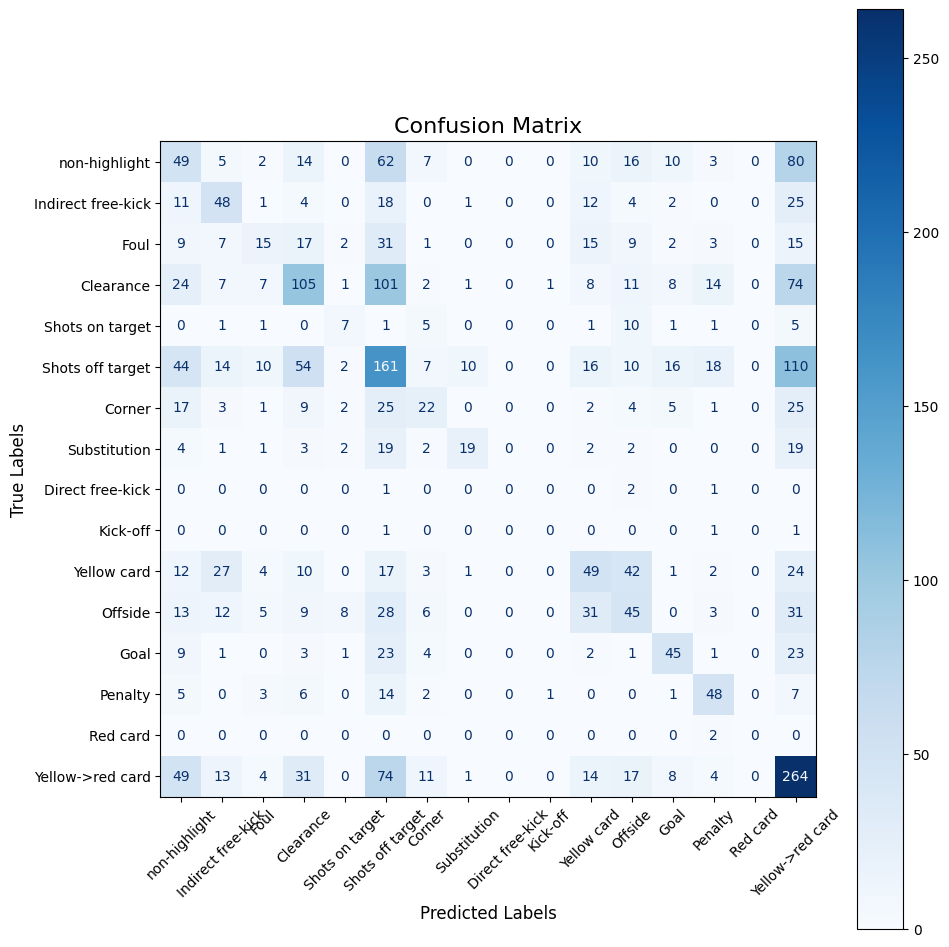

In [ ]:
# data analytics
label_names = [
    "Clearance",
    "Corner",
    "Direct free-kick",
    "Foul",
    "Goal",
    "Indirect free-kick",
    "Kick-off",
    "Offside",
    "Penalty",
    "Red card",
    "Shots off target",
    "Shots on target",
    "Substitution",
    "Yellow card",
    "Yellow->red card",
    "non-highlight"
]

y_preds = np.argmax(predictions.predictions, axis=1)
y_true = test_dataset.labels
accuracy = accuracy_score(y_true, y_preds)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_true, y_preds, target_names=label_names))

cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.tight_layout()
plt.show()